In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import gc
import glob
import os

import cudf
import cupy
from functools import partial
import json
import numpy as np
import nvtabular as nvt
import pandas as pd
from tqdm import tqdm
import pickle 
from sklearn.model_selection import train_test_split
#import generate_xgb_feats
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
tqdm.pandas()

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import cudf
import cupy
import nvtabular as nvt
import json
from pathlib import *
import glob
from functools import partial
from scipy.spatial.distance import cosine

def generate_xgb_feats(data, search_session, mapping,image_matrix, desc_matrix, mapping_id_sku_emb_position): 
    
    # load search data and map product skus 
    # mapping = pd.read_parquet(os.path.join(args.data_path,
    #'categorify_workflow/categories/unique.product_url_hash_first_purchase_id_first_AC_id.parquet'))
    mapping_dict = dict(zip(mapping.product_url_hash_first_purchase_id_first_AC_id, mapping.index))
    # Update mapping with unseen browsing products ids present in flat_product_skus_hash and flat_clicked_skus_hash
    prods = [e for impression in search_session.flat_product_skus_hash.values for e in impression]
    clicked_prod = [e for impression in search_session.flat_clicked_skus_hash.values for e in impression]
    all_prods = set(prods + clicked_prod)
    new_prods = all_prods.difference(set(mapping.product_url_hash_first_purchase_id_first_AC_id))
    print('Number of products present in search and not in browsing data is: %s' %len(new_prods))
    
    cardinality = len(mapping_dict)
    new_ids = list(range(cardinality, cardinality+len(new_prods)))
    new_dict = dict(zip(new_prods, new_ids))
    mapping_dict.update(new_dict)
    search_session.flat_product_skus_hash = search_session.flat_product_skus_hash.progress_apply(lambda x:  [mapping_dict[e] for e in x])
    search_session.flat_clicked_skus_hash = search_session.flat_clicked_skus_hash.progress_apply(lambda x:  [mapping_dict[e] for e in x])
    
    
    
    add_to_cart_data = data.progress_apply(add_to_cart_features, axis=1)
    session_data = data.progress_apply(session_feartures, axis=1)
    p_last_data = data.progress_apply(get_p_last_interactions, axis=1)
    #similarity_data = data.progress_apply(partial(compute_similarity, 
                                                  #image_matrix=image_matrix,
                                                  #desc_matrix=desc_matrix,
                                                # mapping_id_sku_emb_position=mapping_id_sku_emb_position), axis=1)
    

    
    add_to_cart_data = pd.DataFrame(add_to_cart_data.tolist(), columns=[
                                              'add_product_id',
                                              'add_nb_interactions',
                                              'add_has_been_detailed',
                                              'add_has_been_removed',
                                              'add_has_been_searched',
                                              'add_has_been_clicked',
                                              'add_category_hash',
                                              'add_price', 
                                              'add_relative_price'])

    session_data = pd.DataFrame(session_data.tolist(), columns=[
                                              'session_length', 'nb_before_add',
                                              'nb_unique_interactions', 'nb_queries'])

    #similarity_data = pd.DataFrame(similarity_data.tolist(), columns=[ 
                                                                    # 'mean_sim_desc', 'std_sim_desc', 
                                                                     # 'mean_sim_img', 'std_sim_img'])


    p_last_data = pd.DataFrame(p_last_data.tolist(), columns=[
                                              'product_url_id_list',                 
                                              'event_type_list',
                                              'product_action_list',
                                              'category_list', 
                                              'price_list', 
                                              'relative_price_list'])

    p = 5
    # convert list column to multiple columns
    for col in ['product_url_id_list',   'event_type_list',
                'product_action_list', 'category_list', 
                 'price_list', 'relative_price_list']: 
        t = pd.DataFrame(p_last_data[col].to_list(), columns=[col+"-%s"%i for i in range(p)])
        p_last_data = pd.concat([p_last_data, t], axis=1)
        p_last_data.drop(col, axis=1, inplace=True)
    
    # fill missing : replace missing values of categorical by '0'
    for col in ['product_url_id_list',   'event_type_list',
                'product_action_list', 'category_list', 
                 'price_list']: 
        for sub_col in [col+"-%s"%i for i in range(p)]: 
            p_last_data[sub_col] = p_last_data[sub_col].fillna(0)
            
    # fill missing : replace missing values of continuous by the mediane '-0.000199'
    for sub_col in ['relative_price_list'+"-%s"%i for i in range(p)]: 
        p_last_data[sub_col] = p_last_data[sub_col].fillna(-0.000199)
    
    data.reset_index(drop=True, inplace=True),
    p_last_data.reset_index(drop=True, inplace=True), 
    add_to_cart_data.reset_index(drop=True, inplace=True),
    session_data.reset_index(drop=True, inplace=True)
                
    
    xgboost_frame = pd.concat([data[['original_session_id_hash', 'session_id_hash', 
                                     'is_purchased-last', 'nb_after_add-last',
                                     'is_test-last', 'is_valid', 'fold']],
                               p_last_data, 
                               add_to_cart_data,
                               session_data], axis=1)
    
    # fill missing with zeros 
    xgboost_frame = xgboost_frame.fillna(0)
    return xgboost_frame



def compute_similarity(x, image_matrix, desc_matrix, mapping_id_sku_emb_position): 
    product_id = x['add_product_id']
    
    unique_product = list(set(x['product_url_hash_list']))
    
    positions = [mapping_id_sku_emb_position[id] for id in unique_product if id in mapping_id_sku_emb_position]
    
    interaction_desc = desc_matrix[positions]
    interaction_img = image_matrix[positions]
    
    add_interaction_desc = desc_matrix[mapping_id_sku_emb_position[product_id]]
    add_interaction_img = image_matrix[mapping_id_sku_emb_position[product_id]]
    
    similarities_desc = [cosine(add_interaction_desc, b) for b in interaction_desc]
    similarities_img = [cosine(add_interaction_img, b) for b in interaction_img]
    
    return [np.mean(similarities_desc), np.std(similarities_desc), 
            np.mean(similarities_img), np.std(similarities_img)]


def add_to_cart_features(x):
    add_index =  x['product_action-list'].tolist().index(3)
    product_id = x['product_url_hash_list'][add_index]
    product_interactions_index = np.where(x['product_url_hash_list'] == product_id)[0]
    actions = x['product_action-list'][product_interactions_index]
    nb_interactions = len(actions)
    has_been_detailed = 3 in list(actions)
    has_been_removed = 5 in list(actions)
    has_been_clicked = 2 in list(actions)
    if type(x['flat_clicked_skus_hash']) is not float:
        has_been_searched = product_id in x['flat_product_skus_hash']
    else: 
        has_been_searched = 0
    product_category = x['category_hash-list'][add_index]
    product_price = x['price_bucket-list'][add_index]
    product_relative_category_price = x['mean_price_hierarchy-list'][add_index]
    return ( product_id, nb_interactions, has_been_detailed, has_been_removed, 
            has_been_searched, has_been_clicked, product_category,
            product_price, product_relative_category_price)

def session_feartures(x): 
    session_len = len(x['product_url_hash_list'])
    unique_items =  len(set(x['product_url_hash_list']))
    add_index =  x['product_action-list'].tolist().index(3)
    nb_before_add = len(x['product_url_hash_list'][:add_index])
    return [session_len, nb_before_add, unique_items, x['nb_queries']]

def get_p_last_interactions(x, p=5): 
    cols = ['product_url_hash_list', 'event_type-list', 'product_action-list', 'category_hash-list',
           'price_bucket-list', 'mean_price_hierarchy-list']
    last_p_interactions  = [x[col][-p:] for col in cols]
    return  last_p_interactions

In [5]:
# load session browsing data 
OUTPUT_DIR = ''
data = pd.read_parquet("/recsys/session_interactions_task2_preproc2.parquet")
#load product embeddings 
desc_matrix, image_matrix, mapping_id_sku_emb_position = pickle.load(open("/embedding_data_v2.pkl", "rb"))
#load encoded product-ids
mapping = pd.read_parquet("/recsys/categorify_workflow/categories/unique.product_url_hash_first_purchase_id_first_AC_id.parquet")
#load session search data 
search_session = pd.read_parquet( "/recsys/session_search.parquet")
search_session.columns = ['original_session_id_hash', 'flat_query_vector', 'flat_product_skus_hash',
       'flat_clicked_skus_hash', 'impressions_size', 'clicks_size',
       'nb_queries', 'clicked-flag']
# merge browsing and search sessions
data = data.merge(search_session, on='original_session_id_hash', how='left')
data['add_product_id'] = data.progress_apply(lambda x: x['product_url_hash_list'][x['product_action-list'].tolist().index(3)], axis=1)

100%|████████████████████████████████████████████████████████████████████████| 214585/214585 [00:03<00:00, 57494.19it/s]


In [6]:
data['add_product_id'] = data.progress_apply(lambda x: x['product_url_hash_list'][x['product_action-list'].tolist().index(3)], axis=1)

100%|████████████████████████████████████████████████████████████████████████| 214585/214585 [00:03<00:00, 60433.48it/s]


In [7]:
feature_list = [col for col in data.columns if 'list' in col]
feature_list

['product_url_hash_list',
 'event_type-list',
 'product_action-list',
 'category_hash-list',
 'main_category-list',
 'price_bucket-list',
 'mean_price_hierarchy-list',
 'mean_price_main-list',
 'product_sku_hash_list',
 'ts-list',
 'timestamp_hour_cos-list',
 'timestamp_hour_sin-list',
 'timestamp_wd_sin-list',
 'timestamp_wd_cos-list',
 'timestamp_age_days-list',
 'timestamp_age_days_norm-list']

In [8]:
from functools import partial
def truncate_session(x, col): 
    nb_after_add = x['nb_after_add-last']
    add_index = x['product_action-list'].tolist().index(3)
    return x[col][0:int(add_index+nb_after_add+1)]

In [9]:
for col in feature_list:
     data.loc[data.is_valid==1, col] = data.loc[data.is_valid==1, :].progress_apply(partial(truncate_session, col=col), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 98098/98098 [00:01<00:00, 49203.16it/s]


In [10]:
xgboost_frame = generate_xgb_feats(data, search_session, mapping, image_matrix, desc_matrix, mapping_id_sku_emb_position)

  1%|▊                                                                          | 6136/550028 [00:00<01:22, 6559.50it/s]

Number of products present in search and not in browsing data is: 3705


100%|████████████████████████████████████████████████████████████████████████| 214585/214585 [00:07<00:00, 28810.19it/s]


In [11]:

booleans = [col for col in xgboost_frame.columns if 'has_' in col ]
xgboost_frame[booleans] = xgboost_frame[booleans].astype(int)

In [28]:

display(xgboost_frame)



,original_session_id_hash,session_id_hash,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,event_type_list-4,product_action_list-0,product_action_list-1,product_action_list-2,product_action_list-3,product_action_list-4,category_list-0,category_list-1,category_list-2,category_list-3,category_list-4,price_list-0,price_list-1,price_list-2,price_list-3,price_list-4,relative_price_list-0,relative_price_list-1,relative_price_list-2,relative_price_list-3,relative_price_list-4,add_product_id,add_nb_interactions,add_has_been_detailed,add_has_been_removed,add_has_been_searched,add_has_been_clicked,add_category_hash,add_price,add_relative_price,session_length,nb_before_add,nb_unique_interactions,nb_queries
0,6090fea34744108a2b21f6bbf79b19908844bf5d1eeaf2...,3425,0,10,0,1,3,21253,117869.0,61483.0,21502.0,33530.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,2.0,1.0,0,0.0,0.0,23.0,0.0,0,0.0,0.0,4.0,0.0,0.001144,0.001144,0.001144,0.319285,0.001144,5627,2,1,0,0,1,25,3,2.645113,17,6,13,1.0
1,611b14b39be38f198d192ac78dbdba701cf7c510f9d2d9...,3426,0,10,0,0,2,30333,7491.0,20568.0,30015.0,19705.0,1,2.0,2.0,1.0,2.0,1,2.0,2.0,1.0,2.0,0,10.0,10.0,0.0,10.0,0,2.0,2.0,0.0,2.0,0.001144,-0.150178,-0.150178,0.001144,-0.150178,10328,3,1,0,0,1,10,3,-0.150178,113,34,61,2.0
2,68944ef7241850ea6dac70bed34d17513b04689447218f...,3427,0,10,0,0,5,1173,7750.0,10736.0,1684.0,1684.0,2,1.0,1.0,2.0,2.0,2,1.0,1.0,2.0,2.0,1,0.0,0.0,1.0,1.0,2,0.0,0.0,2.0,2.0,0.001144,0.001144,0.001144,0.001144,0.001144,127,8,1,0,0,1,1,2,0.001144,113,71,49,9.0
3,68ebf2d4753c8f2f15647e8bbbf3d76e6e97666d841f3b...,3428,1,10,0,1,2,1809,14186.0,1554.0,1809.0,8.0,2,1.0,1.0,2.0,1.0,2,1.0,1.0,2.0,1.0,34,0.0,0.0,34.0,0.0,5,0.0,0.0,5.0,0.0,0.245745,0.001144,0.001144,0.245745,0.001144,2026,3,1,0,0,1,34,6,0.245745,21,10,14,1.0
4,6ae2fccdc7451805c45339a7aeb003ef8fcabe3d23b907...,3429,1,10,0,0,5,77,2.0,3.0,21.0,119.0,1,1.0,1.0,1.0,2.0,1,1.0,1.0,1.0,6.0,0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,5.0,0.001144,0.001144,0.001144,0.001144,0.001144,119,5,1,0,0,1,1,5,0.001144,113,70,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214580,81d8d1a80eae2cc121db3ff64c71fd8c6ef7c9c42109d2...,183772,0,0,0,0,4,5408,4872.0,5408.0,196.0,3.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,3.0,1.0,0,0.0,0.0,12.0,0.0,0,0.0,0.0,5.0,0.0,0.001144,0.001144,0.001144,0.721112,0.001144,196,1,1,0,0,0,12,5,0.721112,6,4,4,0.0
214581,81dee5e643bbf3e6ac6d37840fd6a434378c5e145d50be...,183773,0,4,0,0,3,3383,4.0,4.0,15605.0,3383.0,3,1.0,1.0,1.0,2.0,5,1.0,1.0,1.0,3.0,8,0.0,0.0,0.0,8.0,2,0.0,0.0,0.0,2.0,2.489871,0.001144,0.001144,0.001144,2.489871,3383,2,1,1,0,0,8,2,2.489871,6,5,4,1.0
214582,81e52d8ce37061045bf19ab8a8c656598194ae036027b7...,183774,0,2,0,1,1,6,16234.0,96.0,96.0,2.0,1,1.0,2.0,2.0,1.0,1,1.0,2.0,3.0,1.0,0,0.0,1.0,1.0,0.0,0,0.0,4.0,4.0,0.0,0.001144,0.001144,0.001144,0.001144,0.001144,96,2,1,0,0,1,1,4,0.001144,6,4,4,0.0
214583,81f294aeca7c2601caabb40a3f1617b5a5412c1f5d20fa...,183775,0,4,0,1,2,209,5899.0,209.0,211.0,209.0,2,1.0,2.0,1.0,2.0,2,1.0,3.0,1.0,2.0,8,0.0,8.0,0.0,8.0,3,0.0,3.0,0.0,3.0,2.489871,0.001144,2.489871,0.001144,2.489871,209,4,1,0,0,1,8,3,2.489871,6,3,3,0.0


In [4]:
xgboost_frame.to_csv('task2.csv')

NameError: name 'xgboost_frame' is not defined

In [4]:
display(dataframe)

,Unnamed: 0,original_session_id_hash,session_id_hash,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,event_type_list-4,product_action_list-0,product_action_list-1,product_action_list-2,product_action_list-3,product_action_list-4,category_list-0,category_list-1,category_list-2,category_list-3,category_list-4,price_list-0,price_list-1,price_list-2,price_list-3,price_list-4,relative_price_list-0,relative_price_list-1,relative_price_list-2,relative_price_list-3,relative_price_list-4,add_product_id,add_nb_interactions,add_has_been_detailed,add_has_been_removed,add_has_been_searched,add_has_been_clicked,add_category_hash,add_price,add_relative_price,session_length,nb_before_add,nb_unique_interactions,nb_queries
0,0,6090fea34744108a2b21f6bbf79b19908844bf5d1eeaf2...,3425,0,10,0,1,3,21253,117869.0,61483.0,21502.0,33530.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,2.0,1.0,0,0.0,0.0,23.0,0.0,0,0.0,0.0,4.0,0.0,0.001144,0.001144,0.001144,0.319285,0.001144,5627,2,1,0,0,1,25,3,2.645113,17,6,13,1.0
1,1,611b14b39be38f198d192ac78dbdba701cf7c510f9d2d9...,3426,0,10,0,0,2,30333,7491.0,20568.0,30015.0,19705.0,1,2.0,2.0,1.0,2.0,1,2.0,2.0,1.0,2.0,0,10.0,10.0,0.0,10.0,0,2.0,2.0,0.0,2.0,0.001144,-0.150178,-0.150178,0.001144,-0.150178,10328,3,1,0,0,1,10,3,-0.150178,113,34,61,2.0
2,2,68944ef7241850ea6dac70bed34d17513b04689447218f...,3427,0,10,0,0,5,1173,7750.0,10736.0,1684.0,1684.0,2,1.0,1.0,2.0,2.0,2,1.0,1.0,2.0,2.0,1,0.0,0.0,1.0,1.0,2,0.0,0.0,2.0,2.0,0.001144,0.001144,0.001144,0.001144,0.001144,127,8,1,0,0,1,1,2,0.001144,113,71,49,9.0
3,3,68ebf2d4753c8f2f15647e8bbbf3d76e6e97666d841f3b...,3428,1,10,0,1,2,1809,14186.0,1554.0,1809.0,8.0,2,1.0,1.0,2.0,1.0,2,1.0,1.0,2.0,1.0,34,0.0,0.0,34.0,0.0,5,0.0,0.0,5.0,0.0,0.245745,0.001144,0.001144,0.245745,0.001144,2026,3,1,0,0,1,34,6,0.245745,21,10,14,1.0
4,4,6ae2fccdc7451805c45339a7aeb003ef8fcabe3d23b907...,3429,1,10,0,0,5,77,2.0,3.0,21.0,119.0,1,1.0,1.0,1.0,2.0,1,1.0,1.0,1.0,6.0,0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,5.0,0.001144,0.001144,0.001144,0.001144,0.001144,119,5,1,0,0,1,1,5,0.001144,113,70,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214580,214580,81d8d1a80eae2cc121db3ff64c71fd8c6ef7c9c42109d2...,183772,0,0,0,0,4,5408,4872.0,5408.0,196.0,3.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,3.0,1.0,0,0.0,0.0,12.0,0.0,0,0.0,0.0,5.0,0.0,0.001144,0.001144,0.001144,0.721112,0.001144,196,1,1,0,0,0,12,5,0.721112,6,4,4,0.0
214581,214581,81dee5e643bbf3e6ac6d37840fd6a434378c5e145d50be...,183773,0,4,0,0,3,3383,4.0,4.0,15605.0,3383.0,3,1.0,1.0,1.0,2.0,5,1.0,1.0,1.0,3.0,8,0.0,0.0,0.0,8.0,2,0.0,0.0,0.0,2.0,2.489871,0.001144,0.001144,0.001144,2.489871,3383,2,1,1,0,0,8,2,2.489871,6,5,4,1.0
214582,214582,81e52d8ce37061045bf19ab8a8c656598194ae036027b7...,183774,0,2,0,1,1,6,16234.0,96.0,96.0,2.0,1,1.0,2.0,2.0,1.0,1,1.0,2.0,3.0,1.0,0,0.0,1.0,1.0,0.0,0,0.0,4.0,4.0,0.0,0.001144,0.001144,0.001144,0.001144,0.001144,96,2,1,0,0,1,1,4,0.001144,6,4,4,0.0
214583,214583,81f294aeca7c2601caabb40a3f1617b5a5412c1f5d20fa...,183775,0,4,0,1,2,209,5899.0,209.0,211.0,209.0,2,1.0,2.0,1.0,2.0,2,1.0,3.0,1.0,2.0,8,0.0,8.0,0.0,8.0,3,0.0,3.0,0.0,3.0,2.489871,0.001144,2.489871,0.001144,2.489871,209,4,1,0,0,1,8,3,2.489871,6,3,3,0.0


In [30]:
dataset.columns

Index(['Unnamed: 0', 'original_session_id_hash', 'session_id_hash',
       'is_purchased-last', 'nb_after_add-last', 'is_test-last', 'is_valid',
       'fold', 'product_url_id_list-0', 'product_url_id_list-1',
       'product_url_id_list-2', 'product_url_id_list-3',
       'product_url_id_list-4', 'event_type_list-0', 'event_type_list-1',
       'event_type_list-2', 'event_type_list-3', 'event_type_list-4',
       'product_action_list-0', 'product_action_list-1',
       'product_action_list-2', 'product_action_list-3',
       'product_action_list-4', 'category_list-0', 'category_list-1',
       'category_list-2', 'category_list-3', 'category_list-4', 'price_list-0',
       'price_list-1', 'price_list-2', 'price_list-3', 'price_list-4',
       'relative_price_list-0', 'relative_price_list-1',
       'relative_price_list-2', 'relative_price_list-3',
       'relative_price_list-4', 'add_product_id', 'add_nb_interactions',
       'add_has_been_detailed', 'add_has_been_removed',
       'add

In [5]:
dataframe = pd.read_csv('task2.csv')

In [22]:
DF = dataframe.drop(['is_test-last', 'is_valid', 'fold','Unnamed: 0','nb_before_add', 'nb_after_add-last' ], axis= 1)


In [26]:
DF = DF.iloc[0:10000]
DF.shape

(10000, 45)

In [27]:
DF.to_csv('task_2.csv')

In [6]:
dataset = pd.DataFrame(dataframe)
purchase = pd.DataFrame(dataframe)

#purchase = pd.DataFrame(xgboost_frame)

In [8]:
import seaborn as sns

In [7]:
displayonly = dataset.drop(['is_test-last', 'is_valid', 'fold','Unnamed: 0', 'original_session_id_hash','session_id_hash','nb_before_add', 'nb_after_add-last' ], axis= 1)


display(displayonly)

,is_purchased-last,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,event_type_list-4,product_action_list-0,product_action_list-1,product_action_list-2,product_action_list-3,product_action_list-4,category_list-0,category_list-1,category_list-2,category_list-3,category_list-4,price_list-0,price_list-1,price_list-2,price_list-3,price_list-4,relative_price_list-0,relative_price_list-1,relative_price_list-2,relative_price_list-3,relative_price_list-4,add_product_id,add_nb_interactions,add_has_been_detailed,add_has_been_removed,add_has_been_searched,add_has_been_clicked,add_category_hash,add_price,add_relative_price,session_length,nb_unique_interactions,nb_queries
0,0,21253,117869.0,61483.0,21502.0,33530.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,2.0,1.0,0,0.0,0.0,23.0,0.0,0,0.0,0.0,4.0,0.0,0.001144,0.001144,0.001144,0.319285,0.001144,5627,2,1,0,0,1,25,3,2.645113,17,13,1.0
1,0,30333,7491.0,20568.0,30015.0,19705.0,1,2.0,2.0,1.0,2.0,1,2.0,2.0,1.0,2.0,0,10.0,10.0,0.0,10.0,0,2.0,2.0,0.0,2.0,0.001144,-0.150178,-0.150178,0.001144,-0.150178,10328,3,1,0,0,1,10,3,-0.150178,113,61,2.0
2,0,1173,7750.0,10736.0,1684.0,1684.0,2,1.0,1.0,2.0,2.0,2,1.0,1.0,2.0,2.0,1,0.0,0.0,1.0,1.0,2,0.0,0.0,2.0,2.0,0.001144,0.001144,0.001144,0.001144,0.001144,127,8,1,0,0,1,1,2,0.001144,113,49,9.0
3,1,1809,14186.0,1554.0,1809.0,8.0,2,1.0,1.0,2.0,1.0,2,1.0,1.0,2.0,1.0,34,0.0,0.0,34.0,0.0,5,0.0,0.0,5.0,0.0,0.245745,0.001144,0.001144,0.245745,0.001144,2026,3,1,0,0,1,34,6,0.245745,21,14,1.0
4,1,77,2.0,3.0,21.0,119.0,1,1.0,1.0,1.0,2.0,1,1.0,1.0,1.0,6.0,0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,5.0,0.001144,0.001144,0.001144,0.001144,0.001144,119,5,1,0,0,1,1,5,0.001144,113,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214580,0,5408,4872.0,5408.0,196.0,3.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,3.0,1.0,0,0.0,0.0,12.0,0.0,0,0.0,0.0,5.0,0.0,0.001144,0.001144,0.001144,0.721112,0.001144,196,1,1,0,0,0,12,5,0.721112,6,4,0.0
214581,0,3383,4.0,4.0,15605.0,3383.0,3,1.0,1.0,1.0,2.0,5,1.0,1.0,1.0,3.0,8,0.0,0.0,0.0,8.0,2,0.0,0.0,0.0,2.0,2.489871,0.001144,0.001144,0.001144,2.489871,3383,2,1,1,0,0,8,2,2.489871,6,4,1.0
214582,0,6,16234.0,96.0,96.0,2.0,1,1.0,2.0,2.0,1.0,1,1.0,2.0,3.0,1.0,0,0.0,1.0,1.0,0.0,0,0.0,4.0,4.0,0.0,0.001144,0.001144,0.001144,0.001144,0.001144,96,2,1,0,0,1,1,4,0.001144,6,4,0.0
214583,0,209,5899.0,209.0,211.0,209.0,2,1.0,2.0,1.0,2.0,2,1.0,3.0,1.0,2.0,8,0.0,8.0,0.0,8.0,3,0.0,3.0,0.0,3.0,2.489871,0.001144,2.489871,0.001144,2.489871,209,4,1,0,0,1,8,3,2.489871,6,3,0.0


In [10]:
from sklearn.ensemble import RandomForestClassifier
import multiprocessing as mp
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random 
from sklearn.model_selection import train_test_split
random.seed(43)
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from xgboost import XGBClassifier

In [11]:
X = dataset.drop(['original_session_id_hash','is_purchased-last','is_test-last', 'is_valid', 'fold','Unnamed: 0','session_id_hash','nb_after_add-last','add_has_been_searched'], axis= 1)
y = purchase['is_purchased-last']

In [10]:
X.head(2)

,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,event_type_list-4,product_action_list-0,product_action_list-1,product_action_list-2,product_action_list-3,product_action_list-4,category_list-0,category_list-1,category_list-2,category_list-3,category_list-4,price_list-0,price_list-1,price_list-2,price_list-3,price_list-4,relative_price_list-0,relative_price_list-1,relative_price_list-2,relative_price_list-3,relative_price_list-4,add_product_id,add_nb_interactions,add_has_been_detailed,add_has_been_removed,add_has_been_clicked,add_category_hash,add_price,add_relative_price,session_length,nb_before_add,nb_unique_interactions,nb_queries
0,21253,117869.0,61483.0,21502.0,33530.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,2.0,1.0,0,0.0,0.0,23.0,0.0,0,0.0,0.0,4.0,0.0,0.001144,0.001144,0.001144,0.319285,0.001144,5627,2,1,0,1,25,3,2.645113,17,6,13,1.0
1,30333,7491.0,20568.0,30015.0,19705.0,1,2.0,2.0,1.0,2.0,1,2.0,2.0,1.0,2.0,0,10.0,10.0,0.0,10.0,0,2.0,2.0,0.0,2.0,0.001144,-0.150178,-0.150178,0.001144,-0.150178,10328,3,1,0,1,10,3,-0.150178,113,34,61,2.0


In [41]:
print(X.shape,y.shape)

(214585, 42) (214585,)


##### account for class imbalance

In [54]:
y.value_counts()

0    168546
1     46039
Name: is_purchased-last, dtype: int64

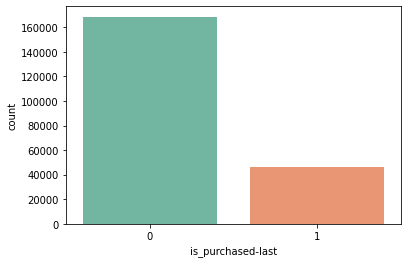

In [61]:
_ = sns.countplot(x='is_purchased-last', 
                  data=dataset, 
                  order=dataset['is_purchased-last'].value_counts().index, 
                  palette='Set2')

In [13]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE


In [14]:
sampler = SMOTETomek()
X_us, y_us = sampler.fit_resample(X, y)


In [78]:
purchased =  pd.DataFrame(y_us)

purchased.head()

,is_purchased-last
0,0
1,0
2,0
3,1
4,1


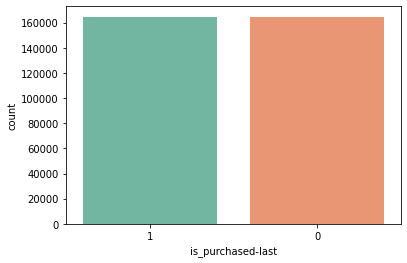

In [80]:
_ = sns.countplot(x='is_purchased-last', 
                  data=purchased, 
                  order=purchased['is_purchased-last'].value_counts().index, 
                  palette='Set2')

In [84]:
print(X_us.shape,y_us.shape)

(329364, 42) (329364,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [16]:
#split with class balance

X_trains, X_tests, y_trains, y_tests = train_test_split(X_us, y_us, test_size=0.25, random_state=5)

#### Random Forest model without tuning

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train) 
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_error = 1 - rf_accuracy
rf_probs = rf.predict_proba(X_test)
print(rf_accuracy, rf_error)


0.9564747329766808 0.04352526702331916


In [82]:
#with balance class
rfus = RandomForestClassifier()
rfus.fit(X_trains, y_trains) 
rfus_pred = rfus.predict(X_tests)
rfus_accuracy = accuracy_score(y_tests, rfus_pred)
rfus_error = 1 - rfus_accuracy
rfus_probs = rfus.predict_proba(X_tests)
print(rfus_accuracy, rfus_error)


0.9724438615027751 0.027556138497224936


In [43]:
rlf = RandomForestClassifier(bootstrap = True,max_depth=110, max_features=4,min_samples_leaf = 5, min_samples_split= 10, n_estimators = 100,class_weight='balanced')
rlf.fit(X_train, y_train) 
rlf_pred = rlf.predict(X_test)
rlf_accuracy = accuracy_score(y_test, rlf_pred)
rlf_error = 1 - rlf_accuracy
rlf_probs = rlf.predict_proba(X_test)
print(rlf_accuracy, rlf_error)

0.9555613547821873 0.04443864521781271


In [17]:
#updated with class balance
rlfus = RandomForestClassifier(bootstrap = True,max_depth=110, max_features=4,min_samples_leaf = 5, min_samples_split= 10, n_estimators = 100)
rlfus.fit(X_trains, y_trains) 
rlfus_pred = rlfus.predict(X_tests)
rlfus_accuracy = accuracy_score(y_tests, rlfus_pred)
rlfus_error = 1 - rlfus_accuracy
rlfus_probs = rlfus.predict_proba(X_tests)
print(rlfus_accuracy, rlfus_error)

0.9659626695183007 0.034037330481699324


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [19]:
scores = cross_val_score(
     rlfus, X, y, cv=5, scoring='f1_macro')
scores

array([0.87797069, 0.8788338 , 0.92995825, 0.96383249, 0.99007111])

In [52]:
scores1 = cross_val_score(
     rlf, X, y, cv=5)

scores1

array([0.92690542, 0.92837337, 0.95805858, 0.97767784, 0.99373209])

##### Gradient Boosting

In [ ]:
clf = GradientBoostingClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)


In [42]:
clf1 = GradientBoostingClassifier(n_estimators=800, learning_rate=.001, max_depth= 5, min_samples_split = 10, min_samples_leaf = 5).fit(X_train, y_train)
clf1.score(X_test, y_test)

0.9557850392379816

In [17]:
#with balance classes defult parameters
clfus = GradientBoostingClassifier()
clfus = clfus.fit(X_trains, y_trains)
clfus.score(X_tests, y_tests)


0.9623824451410659

In [104]:

clfus_pred = clfus.predict(X_tests)

In [18]:
scores = cross_val_score(
     clfus, X, y, cv=5, scoring='f1_macro')
scores

array([0.87785023, 0.87836332, 0.9294594 , 0.96349421, 0.99014183])

In [44]:
clf1.fit(X_train, y_train) 
clf1_pred = clf1.predict(X_test)
clf1_accuracy = accuracy_score(y_test, clf1_pred)
clf1_error = 1 - clf1_accuracy
clf1_probs = clf1.predict_proba(X_test)
print(clf1_accuracy, clf1_error)

0.9557850392379816 0.04421496076201836


In [88]:
#tuned with classbalance

clf1us = GradientBoostingClassifier(n_estimators=800, learning_rate=.001, max_depth= 5, min_samples_split = 10, min_samples_leaf = 5).fit(X_train, y_train)
clf1us.fit(X_trains, y_trains) 
clf1us_pred = clf1us.predict(X_tests)
clf1us_accuracy = accuracy_score(y_tests, clf1us_pred)
clf1us_error = 1 - clf1us_accuracy
clf1us_probs = clf1us.predict_proba(X_tests)
print(clf1us_accuracy, clf1us_error)

0.9342611821571271 0.06573881784287294


parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }


#### XGBoost 

In [19]:
#balance class
boost = XGBClassifier()
boost.fit(X_trains, y_trains)

[18:22:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
scores = cross_val_score(
     boost, X, y, cv=5, scoring='f1_macro')
scores

[18:23:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.87797086, 0.88056222, 0.93332934, 0.96775246, 0.99113354])

In [111]:
# make predictions for test data
boost_pred = boost.predict(X_tests)
# evaluate predictions
accuracy = accuracy_score(y_tests, boost_pred)
boost_error = 1 -accuracy
print(accuracy,boost_error)
#predictions = [round(value) for value in y_pred]

0.973549021751011 0.02645097824898901


In [110]:
# xgboost parameter tunning 
grid_cv.best_params_ = ['gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 3]


final_cl = xgb.XGBClassifier(
    grid_cv.best_params_,
    objective="binary:logistic",
    colsample_bytree=0.5,
    subsample=0.8
)


SyntaxError: invalid syntax (3464410201.py, line 2)

In [47]:
missing_props = y.mean(axis=0)
print(missing_props)

0.21454901321154787


In [24]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 4.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [25]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    #if percent:
    #    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
   # else:
    #    group_percentages = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

##### Random Forest Performance Metrics

<AxesSubplot:>

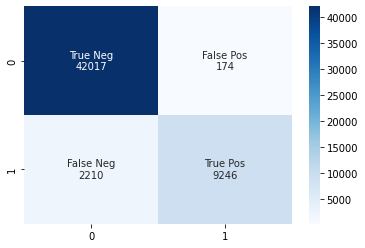

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


rf_conf_matrix  = metrics.confusion_matrix(y_test, rlf_pred)
conf_mat_rf = pd.DataFrame(
    rf_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
#print(conf_mat_rf)

#sns.heatmap(rf_conf_matrix/np.sum(rf_conf_matrix), annot=True, 
            #fmt='.2%', cmap='Blues')
#sns.heatmap(rf_conf_matrix, annot=True)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                rf_conf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_conf_matrix, annot=labels, fmt='', cmap='Blues')

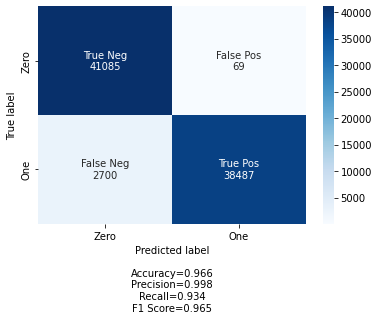

In [100]:
rf_conf_matrix  = metrics.confusion_matrix(y_tests, rlfus_pred)
conf_mat_rf = pd.DataFrame(
    rf_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
#print(conf_mat_rf)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(rf_conf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [102]:
fi = pd.DataFrame({'feature': list(X_tests.columns),
                   'importance': rlfus.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
14,product_action_list-4,0.204534
13,product_action_list-3,0.097768
2,product_url_id_list-2,0.076530
9,event_type_list-4,0.074645
4,product_url_id_list-4,0.065356


<AxesSubplot:>

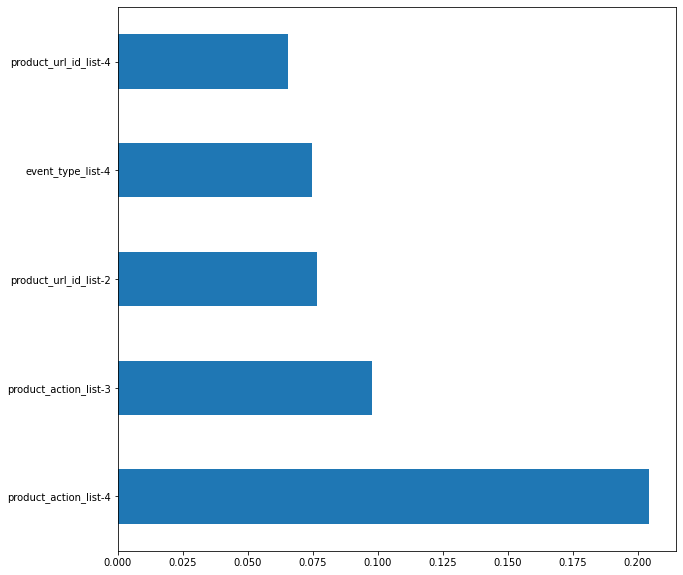

In [136]:
rffeat_importances = pd.Series(rlfus.feature_importances_, index=X_us.columns)
rffeat_importances = rffeat_importances.nlargest(5)
rffeat_importances.plot(kind='barh' , figsize=(10,10))

#### Performance Metrics Gradient Boost 

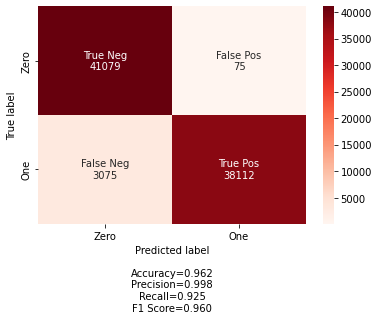

In [106]:
clf1_conf_matrix  = metrics.confusion_matrix(y_tests, clfus_pred)
conf_mat_rf = pd.DataFrame(
    clf1_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
#print(conf_mat_rf)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(clf1_conf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [107]:
figrad = pd.DataFrame({'feature': list(X_tests.columns),
                   'importance': clfus.feature_importances_}).\
                    sort_values('importance', ascending = False)
figrad.head()

,feature,importance
14,product_action_list-4,0.638925
13,product_action_list-3,0.254433
38,session_length,0.023738
41,nb_queries,0.020441
12,product_action_list-2,0.010472


<AxesSubplot:>

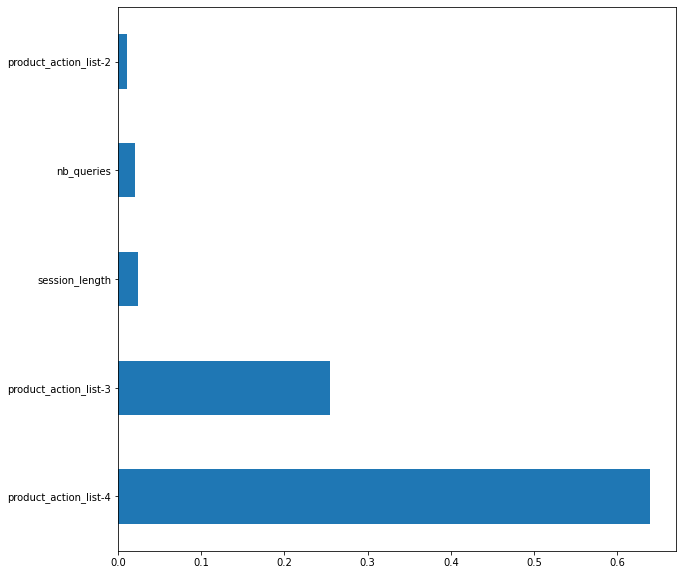

In [135]:
gbfeat_importances = pd.Series(clfus.feature_importances_, index=X_us.columns)
gbfeat_importances = gbfeat_importances.nlargest(5)
gbfeat_importances.plot(kind='barh' , figsize=(10,10))

#### xgBoost performance metrics 

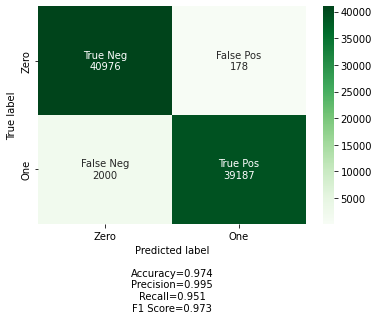

In [121]:
xg_conf_matrix  = metrics.confusion_matrix(y_tests, boost_pred)
conf_mat_rf = pd.DataFrame(
    clf1_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"]
)
#print(conf_mat_rf)


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(xg_conf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Greens')

In [122]:
fixg = pd.DataFrame({'feature': list(X_tests.columns),
                   'importance': boost.feature_importances_}).\
                    sort_values('importance', ascending = False)
fixg.head()

,feature,importance
14,product_action_list-4,0.322126
13,product_action_list-3,0.275112
6,event_type_list-1,0.064769
7,event_type_list-2,0.055811
41,nb_queries,0.053012


In [124]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(boost, X_tests, y_tests)

<AxesSubplot:>

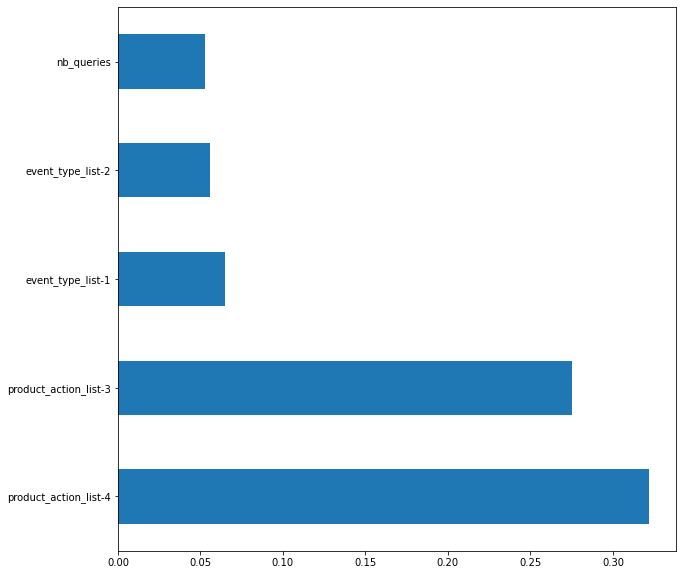

In [133]:
xgfeat_importances = pd.Series(boost.feature_importances_, index=X_us.columns)
xgfeat_importances = xgfeat_importances.nlargest(5)
xgfeat_importances.plot(kind='barh' , figsize=(10,10))

#### Random Grid Search for best parameters 

In [16]:
from pprint import pprint

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 3.9min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=13.4min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 3.9min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=14.3min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 4.4min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=14.2min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400

KeyboardInterrupt: 

In [21]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.0439 degrees.
Accuracy = -inf%.


In [22]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [24]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [26]:
grid_search.fit(X_train,y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test,y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  29.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time= 4.1min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=  52.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 4.2min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time= 1.3min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000; total time= 4.1min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=  49.0s

In [27]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test,y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.0440 degrees.
Accuracy = -inf%.
Improvement of nan%.
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time= 6.9min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.5min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  41.8s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time= 1.2min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time= 1.8min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 5.7min
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimator

In [29]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(X_train,y_train);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [30]:
grid_search_final.best_params_


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  36.9s
[CV] END bootstrap=True, max_depth=120, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  36.2s
[CV] END bootstrap=True, max_depth=120, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=75; total time=  33.2s
[CV] END bootstrap=True, max_depth=None, max_features=3, min_samples_leaf=7, min_samples_split=10, n_estimators=75; total time=  30.3s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=75; total time=  26.0s
[CV] END bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=125; total time=  57.4s
[CV] END bootstrap=True, max_depth=120, max_features=4, min_samples_leaf=7, min_samples_split=10, n_estimators=125; total time=  55.6s
[CV] END bootstrap=True, max_depth=110, max_features=4, m

In [38]:
def evaluate(model, X_test,y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [40]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train,y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.0606 degrees.
Accuracy = -inf%.


In [46]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test,y_test)

Model Performance
Average Error: 0.0440 degrees.
Accuracy = -inf%.


In [41]:
# Time used for evaluating model run times
import time

In [51]:
#Evaluate run time and accuracy

def evaluate_model(model, X_train, y_train, X_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = X_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

In [54]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, X_test,y_test)

Final Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 0.0440 degrees.
Accuracy = -inf%.


In [55]:
final_model_results = evaluate_model(best_grid, X_train, y_train, X_test, y_test)
final_model_results['model'] = 'second_grid'

In [56]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [58]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

In [61]:
para_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [71]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gf = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
#print(clf.score(X_train,y_train)
#print(clf.best_params_)

PicklingError: Could not pickle the task to send it to the workers.